In [1]:
import sys
sys.path.append('../dqn/')
from gym import wrappers
from atari_wrappers import *
from dqn_utils import *
import random
import os.path as osp
import gym
import time
import sys
import imp
imp.reload(gym)
imp.reload(wrappers)

<module 'gym.wrappers' from '/Users/chris/anaconda/envs/env_class_deepRL/lib/python3.5/site-packages/gym/wrappers/__init__.py'>

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Exploring CQ

In [43]:
sys.path.append('../crystal_quest/')
import crystal_quest_env as cq
import imp 
imp.reload(cq) # reload after making changes

<module 'crystal_quest_env' from '../crystal_quest/crystal_quest_env.py'>

In [56]:
env = cq.Wave1Env(num_aliens=2,num_crystals=20,num_asteroids=1,obs_type=0)

In [57]:
print(env.observation_space)
print(env.action_space)

Box(39, 25, 4)
Discrete(5)


In [58]:
type(env.observation_space)

gym.spaces.box.Box

In [59]:
type(env.observation_space) == gym.spaces.Box

True

In [60]:
obs = env.reset()


In [61]:
env.ship_location

array([19, 11])

In [62]:
env.ship_velocity

array([0, 1])

In [63]:
#

In [64]:
replay_buffer = ReplayBuffer(1000, 1)
last_obs = env.reset()


for t in range(1000):
    idx = replay_buffer.store_frame(last_obs)
    recent_history= replay_buffer.encode_recent_observation()
    action = env.action_space.sample()
    obs, reward, done,info = env.step(action)
    replay_buffer.store_effect(idx,action,reward,done)
    if done:
        obs = env.reset()
    last_obs= obs.copy()

In [65]:
env.alien_locations

array([[ 34.,   0.],
       [  6.,   2.]])

In [67]:
replay_buffer.reward[0:20]

array([ -1.,  -1.,  49.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
        -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  49.], dtype=float32)

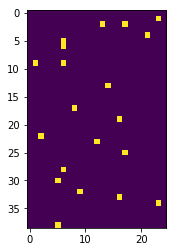

In [79]:
plt.imshow(replay_buffer.obs[89,:,:,1])

In [82]:
batch_size=32
obs_t_batch, act_t_batch, rew_batch, obs_tp1_batch, done_mask = replay_buffer.sample(batch_size)


In [83]:
act_t_batch

array([3, 1, 4, 3, 0, 0, 3, 4, 4, 0, 1, 2, 1, 3, 1, 1, 0, 1, 3, 4, 2, 4, 3,
       2, 1, 1, 4, 2, 2, 0, 0, 4], dtype=int32)

In [84]:
obs_t_batch.shape

(32, 39, 25, 4)

In [86]:
obs_t_batch[0,:].shape

(39, 25, 4)

In [88]:
obs_t_batch[6,:].shape

(39, 25, 4)

In [90]:
np.array([-2.0]).astype('uint8')

array([254], dtype=uint8)

In [91]:
rew_batch[6]

-1.0

In [92]:
done_mask

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)

In [95]:
#obs_t_batch[1,:]/255

# Manual Control

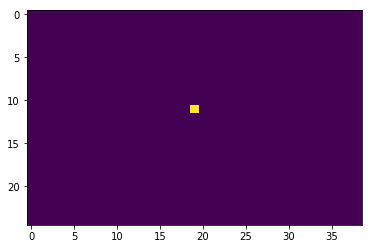

In [102]:
env = cq.Wave1Env(num_aliens=1,num_crystals=50,num_asteroids=1,obs_type=0)
obs = env.reset()
plt.imshow(obs[:,:,0].T)

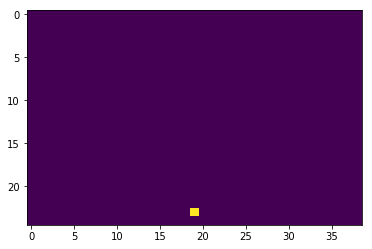

In [114]:
obs, reward, done,info = env.step(2)
plt.imshow(obs[:,:,0].T)

# Testing Feature Obs

In [115]:
sys.path.append('../crystal_quest/')
import crystal_quest_env as cq
import imp 
imp.reload(cq) # reload after making changes
env = cq.Wave1Env(num_aliens=1,num_crystals=20,num_asteroids=10,obs_type=2)
obs = env.reset()


[ 1.  3.  1. -1.  2.  1. -1.  1. -1.]


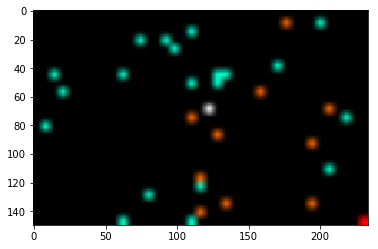

In [116]:
obs,_,_,_=env.step(env.action_space.sample())
print(obs)
plt.imshow(env._return_img())

# Testing Window Obs

In [137]:
sys.path.append('../crystal_quest/')
import crystal_quest_env as cq
import imp 
imp.reload(cq) # reload after making changes
env = cq.Wave1Env(num_aliens=1,num_crystals=10,num_asteroids=20,obs_type=3,relative_window=(25,25))
obs = env.reset()


In [138]:
obs,_,_,_=env.step(env.action_space.sample())

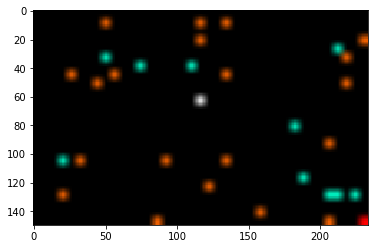

In [139]:
plt.imshow(env._return_img())

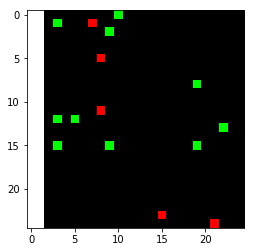

In [144]:
plt.imshow(obs,)

# Custom TF Reward Functions

In [42]:
import sys
sys.path.append('../crystal_quest/')
sys.path.append('../dqn/')
from gym import wrappers
from atari_wrappers import *
from dqn_utils import *
import random
import gym
import sys
import imp
import crystal_quest_env as cq
import reward_functions
imp.reload(cq) # reload after making changes
imp.reload(gym)
imp.reload(wrappers)
imp.reload(reward_functions)
from reward_functions import *

In [43]:
# set up a tf session
tf.reset_default_graph()
tf_config = tf.ConfigProto(
    inter_op_parallelism_threads=1,
    intra_op_parallelism_threads=1)
session = tf.Session(config=tf_config)

In [44]:
reward_func = SimpleRewardFunction(session)

In [45]:
env = cq.Wave1Env(num_aliens=1,num_crystals=10,num_asteroids=20,
                  obs_type=3,relative_window=(25,25),
                 reward_func=reward_func)
obs = env.reset()

In [46]:
tf.global_variables_initializer().run(session=session)
reward_func.set_phi(np.array([2.0,-2.0,-1.0]))

In [47]:
reward_func.sess.run(reward_func.phi)

array([ 2., -2., -1.], dtype=float32)

- importantly you need to set phi *after* variable initially

In [48]:
reward_func.sess.run(reward_func.b)

array([ 0.], dtype=float32)

In [49]:
env.alien_collision=1.0

In [50]:
reward_func.calculate_reward(env)

array([[-2.]], dtype=float32)

In [51]:
reward_func.sess.run(tf.expand_dims(reward_func.phi,1))

array([[ 2.],
       [-2.],
       [-1.]], dtype=float32)

In [11]:
for i in range(200):
    obs,rew,done,info=env.step(env.action_space.sample())
    print((env.crystal_captured,env.alien_collision,env.asteroid_collision))
    print(rew)
    print('')

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[ 0.]]

(0, 0, 0)
[[

- ok cool it's calculating the reward quickly, with no obvious slow down.

### now loading in features to calculate loss

In [398]:
crystals = np.loadtxt('../dqn/cq_gr_truth1/gym/episode_crystals2017-11-25-15:50.txt')
aliens = np.loadtxt('../dqn/cq_gr_truth1/gym/episode_alien_collisions2017-11-25-15:50.txt')
asteroids = np.loadtxt('../dqn/cq_gr_truth1/gym/episode_asteroid_collisions2017-11-25-15:50.txt')


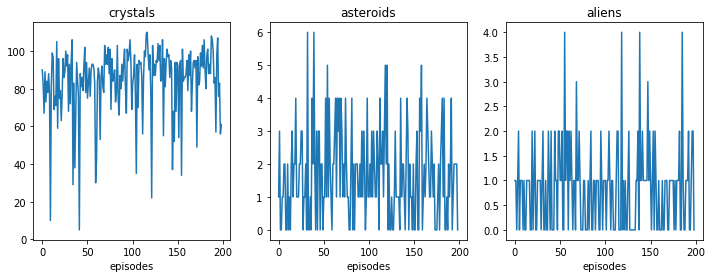

In [404]:
plt.figure(figsize=(8,4))
fig,axes=plt.subplots(1,3,figsize=(12,4))
axes[0].plot(crystals[-200:-1])
axes[0].set_title('crystals')
axes[1].plot(asteroids[-200:-1])
axes[1].set_title('asteroids')
axes[2].plot(aliens[-200:-1])
axes[2].set_title('aliens')
for ax in axes:
    ax.set_xlabel('episodes')


In [406]:
features_demo = np.vstack((crystals[-100:-1:],aliens[-100:-1:],asteroids[-100:-1:])).T
features_demo2 = features_demo.copy()

In [416]:
phi_last = reward_func.sess.run(reward_func.phi)

batch_size=1000
batch_idx = np.random.choice(range(len(features_demo)),size=batch_size)
batch_idx2 = np.random.choice(range(len(features_demo)),size=batch_size)
loss = reward_func.update(features_demo[batch_idx,:],features_demo2[batch_idx2,:])
print('learning rate %f' % reward_func.learning_rate)
print('loss %f' %loss)
phi = reward_func.sess.run(reward_func.phi)
print('phi:')
print(phi)
print('weight change %f' % np.linalg.norm(phi-phi_last))
phi=phi_last
print('bias')
print(reward_func.sess.run(reward_func.b))

learning rate 0.001000
loss -0.629715
phi:
[ 1.97092116 -1.97814858 -0.97707009]
weight change 0.000149
bias
[ 0.]


# can I find the right features with random samples?



In [375]:
import sys
sys.path.append('../crystal_quest/')
sys.path.append('../dqn/')
from gym import wrappers
from atari_wrappers import *
from dqn_utils import *
import random
import gym
import sys
import imp
import crystal_quest_env as cq
import reward_functions
imp.reload(cq) # reload after making changes
imp.reload(gym)
imp.reload(wrappers)
imp.reload(reward_functions)
from reward_functions import *

In [376]:
# set up a tf session
tf.reset_default_graph()
tf_config = tf.ConfigProto(
    inter_op_parallelism_threads=1,
    intra_op_parallelism_threads=1)
session = tf.Session(config=tf_config)

In [377]:
reward_func = SimpleRewardFunction(session)

In [378]:
tf.global_variables_initializer().run(session=session)
reward_func.set_phi(np.random.random(3))

In [379]:
env = cq.Wave1Env(num_aliens=1,num_crystals=10,num_asteroids=20,
                  obs_type=3,relative_window=(25,25),
                 reward_func=reward_func)


In [380]:
# load demonstration samples 
crystals = np.loadtxt('../dqn/cq_gr_truth1/gym/episode_crystals2017-11-25-15:50.txt')[-200:-1]
aliens = np.loadtxt('../dqn/cq_gr_truth1/gym/episode_alien_collisions2017-11-25-15:50.txt')[-200:-1]
asteroids = np.loadtxt('../dqn/cq_gr_truth1/gym/episode_asteroid_collisions2017-11-25-15:50.txt')[-200:-1]

features_demo = np.vstack((crystals,aliens,asteroids)).T
features_demo.shape

(199, 3)

In [389]:
# generate background samples 
samp_episode_crystals = []
samp_episode_alien = []
samp_episode_asteroids = []
obs = env.reset()
episode_count = 0
for i in range(100000):
    obs,rew,done,info=env.step(env.action_space.sample())
    if done:
        samp_episode_crystals.append(env.episode_crystals_captured)
        samp_episode_asteroids.append(env.episode_asteroid_collisions)
        samp_episode_alien.append(env.episode_alien_collisions)
        obs = env.reset()
        episode_count+=1
print('episodes %d' % episode_count)


episodes 166


In [390]:
features_sample = np.vstack((samp_episode_crystals,samp_episode_alien,samp_episode_asteroids)).T
features_sample.shape

(166, 3)

In [391]:
#features_demo[batch_idx,:]

In [392]:
features_demo[:,:].mean(axis=0)

array([ 84.24120603,   0.83919598,   1.68844221])

In [393]:
features_sample.mean(axis=0)

array([ 2.54819277,  0.63855422,  8.59638554])

In [394]:
np.vstack((features_sample[batch_idx_samp,:],features_demo[batch_idx,:])).mean(axis=0)

array([ 44.085,   0.735,   6.095])

In [395]:
#np.vstack((features_sample[batch_idx_samp,:],features_demo[batch_idx]))
batch_idx_samp

array([0, 0, 8, 2, 4, 4, 2, 6, 3, 6, 8, 4, 5, 3, 7, 4, 4, 3, 1, 3, 7, 3, 2,
       0, 1, 6, 7, 7, 6, 6, 7, 0, 8, 1, 8, 1, 5, 0, 5, 0, 7, 7, 1, 1, 1, 8,
       2, 2, 4, 5, 8, 1, 0, 4, 5, 4, 3, 1, 1, 4, 8, 1, 6, 3, 0, 0, 1, 7, 8,
       4, 3, 2, 2, 4, 0, 2, 4, 3, 3, 6, 0, 5, 4, 8, 7, 2, 1, 8, 2, 2, 0, 5,
       2, 0, 7, 5, 0, 3, 6, 8])

In [410]:
# update reward function 
batch_size=100
K=10000
for k in range(K):
    batch_idx = np.random.choice(range(len(features_demo)),size=batch_size)
    batch_idx_samp = np.random.choice(range(len(samp_episode_crystals)),size=batch_size)

    loss = env.reward_func.update(features_demo[batch_idx,:],
                        np.vstack((features_sample[batch_idx_samp,:],features_demo[batch_idx,:])))
    
    #loss = env.reward_func.update(features_demo[batch_idx,:],
    #                              features_demo[batch_idx_samp,:])
    
    if k%1000==0:
        print('learning rate %f' % env.reward_func.learning_rate)
        print('loss %f' %loss)
        phi = session.run(env.reward_func.phi)
        print('phi:')
        print(phi)
        #print('weight change %f' % np.linalg.norm(phi-phi_last))
        #phi=phi_last
        print('bias')
        bias = session.run(env.reward_func.b)
        print(bias)

learning rate 0.000100
loss -213.547974
phi:
[-5.27258778  0.58915794 -0.34179804]
bias
[ 0.]
learning rate 0.000100
loss -369.172607
phi:
[ -9.35324192e+00   5.79255402e-01   3.57669685e-03]
bias
[ 0.]
learning rate 0.000100
loss -537.164185
phi:
[-13.44097614   0.56925273   0.34774458]
bias
[ 0.]
learning rate 0.000100
loss -709.052917
phi:
[-17.52997017   0.55907691   0.69338244]
bias
[ 0.]
learning rate 0.000100
loss -907.379517
phi:
[-21.61384773   0.54928917   1.03999317]
bias
[ 0.]
learning rate 0.000100
loss -1078.557495
phi:
[-25.69898605   0.53916693   1.38375747]
bias
[ 0.]
learning rate 0.000100
loss -1194.131714
phi:
[-29.78385353   0.52935731   1.72863686]
bias
[ 0.]
learning rate 0.000100
loss -1375.324097
phi:
[-33.86523438   0.51939243   2.07460785]
bias
[ 0.]
learning rate 0.000100
loss -1563.463745
phi:
[-37.9523201    0.50907642   2.41986966]
bias
[ 0.]
learning rate 0.000100
loss -1757.382202
phi:
[-42.03945923   0.49903926   2.76576638]
bias
[ 0.]


In [411]:
w = np.ones((np.shape(features_sample)[0],1))

In [412]:
feed_dict = {env.reward_func.batch_demo_features:features_demo,
        env.reward_func.batch_sample_features:features_sample,
        env.reward_func.w:w,
    }

In [413]:
phi = session.run(env.reward_func.phi)
phi

array([-46.12070084,   0.4890537 ,   3.11105013], dtype=float32)

In [414]:
features_sample[0:5,:]

array([[ 4,  1, 10],
       [ 1,  0, 10],
       [ 1,  0, 11],
       [ 1,  0, 15],
       [ 1,  0,  7]])

In [415]:
np.dot(features_sample[0:5,:],phi)

array([-152.88324836,  -15.01019955,  -11.89914942,    0.5450511 ,
        -24.34334993])

In [416]:
session.run(env.reward_func.samp_r,feed_dict=feed_dict)[0:5,:]

array([[-152.88323975],
       [ -15.0102005 ],
       [ -11.89915085],
       [   0.54505157],
       [ -24.34334946]], dtype=float32)

In [417]:
np.dot(features_demo[0:5,:],phi)

array([-4147.26297143, -3772.07526448, -3090.08695602, -4104.25332072,
       -3362.72200352])

In [418]:
session.run(env.reward_func.demo_r,feed_dict=feed_dict)[0:5,:]

array([[-4147.26318359],
       [-3772.07519531],
       [-3090.08691406],
       [-4104.25292969],
       [-3362.72216797]], dtype=float32)

In [419]:
np.dot(features_demo[0:5,:],phi)-np.dot(features_sample[0:5,:],phi)

array([-3994.37972307, -3757.06506494, -3078.18780661, -4104.79837182,
       -3338.37865359])

- the feature counts getting further apart also decreases the loss function 
- (can I square it?)
- what does this mean? 
- 

In [420]:
session.run(env.reward_func.irl_loss,feed_dict=feed_dict)

-3789.1323

In [421]:
session.run(tf.gradients(env.reward_func.irl_loss,env.reward_func.phi),feed_dict=feed_dict)

[array([ 81.69300079,   0.20064187,  -6.90794277], dtype=float32)]

In [422]:
features_demo[:,:].mean(axis=0)-features_sample[:,:].mean(axis=0)

array([ 81.69301326,   0.20064176,  -6.90794333])

In [423]:
env.reward_func.learning_rate*session.run(tf.gradients(env.reward_func.irl_loss,env.reward_func.phi),feed_dict=feed_dict)[0]

array([  8.16929992e-03,   2.00641862e-05,  -6.90794259e-04], dtype=float32)

In [426]:
phi

array([-46.12070084,   0.4890537 ,   3.11105013], dtype=float32)

In [271]:
phi = session.run(env.reward_func.phi)

In [274]:
type(phi)
phi.dtype

dtype('float32')

In [277]:
type(gstep)

numpy.ndarray

In [276]:
gstep.dtype

dtype('float32')

In [372]:
print(phi)
gstep=env.reward_func.learning_rate*session.run(tf.gradients(env.reward_func.irl_loss,env.reward_func.phi),feed_dict=feed_dict)[0]
print(gstep)
phi=phi+gstep
print(phi)

[ 0.63665801  3.31419849  1.17178202]
[  8.15122854e-03   2.30762289e-05  -8.03444826e-04]
[ 0.64480925  3.31422162  1.17097855]


In [374]:
env.reward_func.train_op.

()

In [438]:
[np.sum(np.abs(env.ship_location-ast_loc)) for ast_loc in env.asteroid_locations]


[20, 3, 27, 11, 26, 11, 9, 6, 10, 15, 15, 8, 23, 9, 18, 24, 16, 8, 27, 12]

In [441]:
import matplotlib.pyplot as plt
%matplotlib inline

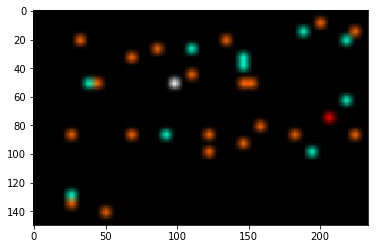

In [442]:
plt.imshow(env._return_img())

In [464]:
getattr(env,'ship_location')

array([16,  8])